# 1. Thư viện

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Thu thập và xử lý dữ liệu

Mounted at /content/drive
Phân phối nhãn VPN vs Non-VPN:
vpn_label
1    28886
0    28710
Name: count, dtype: int64


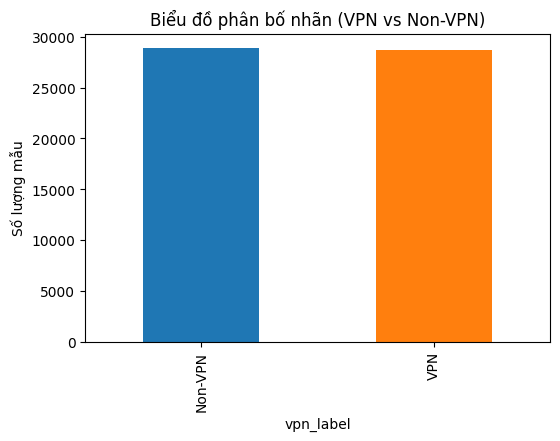

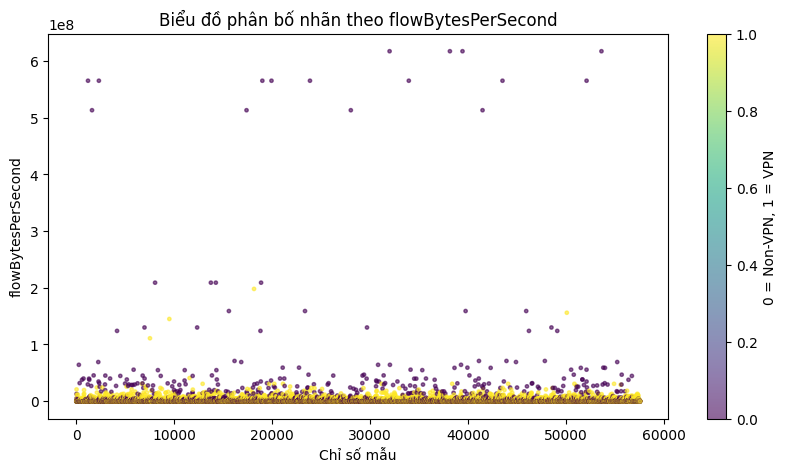

In [2]:
from google.colab import drive
drive.mount('/content/drive')
input_csv = "/content/drive/MyDrive/Goc/consolidated_traffic_data.csv"
df = pd.read_csv(input_csv)
df = df.dropna()

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Tạo nhãn nhị phân VPN vs Non-VPN
df["vpn_label"] = df["traffic_type"].apply(lambda x: 1 if str(x).startswith("VPN") else 0)

print("Phân phối nhãn VPN vs Non-VPN:")
print(df["vpn_label"].value_counts())

# === Biểu đồ bar phân phối nhãn ===
plt.figure(figsize=(6,4))
df["vpn_label"].value_counts().plot(kind="bar", color=["tab:blue","tab:orange"])
plt.title("Biểu đồ phân bố nhãn (VPN vs Non-VPN)")
plt.xticks([0,1], ["Non-VPN","VPN"])
plt.ylabel("Số lượng mẫu")
plt.show()

# === Scatter plot trực quan hóa nhãn ===
plt.figure(figsize=(10,5))
plt.scatter(df.index, df["flowBytesPerSecond"], c=df["vpn_label"], cmap="viridis", s=6, alpha=0.6)
plt.title("Biểu đồ phân bố nhãn theo flowBytesPerSecond")
plt.xlabel("Chỉ số mẫu")
plt.ylabel("flowBytesPerSecond")
plt.colorbar(label="0 = Non-VPN, 1 = VPN")
plt.show()


feature_cols = [
    'duration','total_fiat','total_biat','min_fiat','min_biat','max_fiat','max_biat',
    'mean_fiat','mean_biat','flowPktsPerSecond','flowBytesPerSecond','min_flowiat',
    'max_flowiat','mean_flowiat','std_flowiat','min_active','mean_active','max_active',
    'std_active','min_idle','mean_idle','max_idle','std_idle'
]

X = df[feature_cols].values
y = df["vpn_label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Chia dữ liệu

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

n_features = X_train.shape[1]
X_train_r = X_train.reshape(-1, n_features, 1)
X_test_r = X_test.reshape(-1, n_features, 1)

# 4. Hàm tạo callback

In [4]:
def get_callbacks(patience_es=8, patience_rlrp=4):
    es = EarlyStopping(
        monitor='val_loss',
        patience=patience_es,
        restore_best_weights=True
    )
    rlrp = ReduceLROnPlateau(
        monitor='val_loss',
        patience=patience_rlrp,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )
    return [es, rlrp]

# 5. Định nghĩa Mô hình

## 5.1 MLP

In [5]:
def build_mlp(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## 5.2 CNN

In [6]:
def build_cnn(n_features):
    model = Sequential([
        Input(shape=(n_features,1)),
        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## 5.3 LSTM

In [7]:
def build_lstm(n_features):
    model = Sequential([
        Input(shape=(n_features,1)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 6. Hàm đo thời gian

In [8]:
def train_measure(model, X, y, **fit_kwargs):
    t0 = time.time()
    hist = model.fit(X, y, **fit_kwargs)
    t1 = time.time()
    return hist, (t1 - t0)

def test_measure(model, X):
    t0 = time.time()
    preds = model.predict(X, verbose=0)
    t1 = time.time()
    return preds, (t1 - t0)

# 7. Huấn luyện mô hình

In [9]:
results = {}
histories = {}

## 7.1 MLP

In [10]:
print("\n===== HUẤN LUYỆN MLP =====")
mlp = build_mlp(n_features)

hist_mlp, train_time_mlp = train_measure(
    mlp, X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=get_callbacks(),
    verbose=1
)

y_proba_mlp, test_time_mlp = test_measure(mlp, X_test)
y_pred_mlp = (y_proba_mlp > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred_mlp))

results["MLP"] = {
    "acc": accuracy_score(y_test, y_pred_mlp),
    "f1": f1_score(y_test, y_pred_mlp),
    "train_time": train_time_mlp,
    "test_time": test_time_mlp
}
histories["MLP"] = hist_mlp


===== HUẤN LUYỆN MLP =====
Epoch 1/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5531 - loss: 0.7457 - val_accuracy: 0.6074 - val_loss: 0.6550 - learning_rate: 0.0010
Epoch 2/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5933 - loss: 0.6592 - val_accuracy: 0.6305 - val_loss: 0.6434 - learning_rate: 0.0010
Epoch 3/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6067 - loss: 0.6482 - val_accuracy: 0.6332 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 4/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6175 - loss: 0.6384 - val_accuracy: 0.6401 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 5/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6289 - loss: 0.6321 - val_accuracy: 0.6376 - val_loss: 0.6260 - learning_rate: 0.0010
Epoch 6/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6330 - loss: 0.6257 - val_accuracy: 0.6395 - val_loss: 0.6287 - learning_rate: 0.0010
Epoch 7/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accura

## 7.2 CNN

In [11]:
print("\n===== HUẤN LUYỆN CNN =====")
cnn = build_cnn(n_features)

hist_cnn, train_time_cnn = train_measure(
    cnn, X_train_r, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=get_callbacks(),
    verbose=1
)

y_proba_cnn, test_time_cnn = test_measure(cnn, X_test_r)
y_pred_cnn = (y_proba_cnn > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred_cnn))

results["CNN"] = {
    "acc": accuracy_score(y_test, y_pred_cnn),
    "f1": f1_score(y_test, y_pred_cnn),
    "train_time": train_time_cnn,
    "test_time": test_time_cnn
}
histories["CNN"] = hist_cnn


===== HUẤN LUYỆN CNN =====
Epoch 1/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5783 - loss: 0.7582 - val_accuracy: 0.6156 - val_loss: 0.6459 - learning_rate: 0.0010
Epoch 2/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6274 - loss: 0.6398 - val_accuracy: 0.6564 - val_loss: 0.6236 - learning_rate: 0.0010
Epoch 3/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6351 - loss: 0.6262 - val_accuracy: 0.6627 - val_loss: 0.6095 - learning_rate: 0.0010
Epoch 4/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6491 - loss: 0.6150 - val_accuracy: 0.6766 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 5/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6568 - loss: 0.6041 - val_accuracy: 0.6824 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 6/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6670 - loss: 0.5940 - val_accuracy: 0.6890 - val_loss: 0.5842 - learning_rate: 0.0010
Epoch 7/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/st

## 7.3 LSTM

In [12]:
print("\n===== HUẤN LUYỆN LSTM =====")
lstm = build_lstm(n_features)

hist_lstm, train_time_lstm = train_measure(
    lstm, X_train_r, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=get_callbacks(patience_es=10, patience_rlrp=5),
    verbose=1
)

y_proba_lstm, test_time_lstm = test_measure(lstm, X_test_r)
y_pred_lstm = (y_proba_lstm > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred_lstm))

results["LSTM"] = {
    "acc": accuracy_score(y_test, y_pred_lstm),
    "f1": f1_score(y_test, y_pred_lstm),
    "train_time": train_time_lstm,
    "test_time": test_time_lstm
}
histories["LSTM"] = hist_lstm


===== HUẤN LUYỆN LSTM =====
Epoch 1/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.5505 - loss: 0.6794 - val_accuracy: 0.5749 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 2/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.5801 - loss: 0.6644 - val_accuracy: 0.5849 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 3/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.5919 - loss: 0.6610 - val_accuracy: 0.6100 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 4/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.5976 - loss: 0.6580 - val_accuracy: 0.5828 - val_loss: 0.6512 - learning_rate: 0.0010
Epoch 5/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.5987 - loss: 0.6503 - val_accuracy: 0.6208 - val_loss: 0.6403 - learning_rate: 0.0010
Epoch 6/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.6039 - loss: 0.6499 - val_accuracy: 0.6163 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 7/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 47s 82m

# 8. Ma trận nhầm lẫn

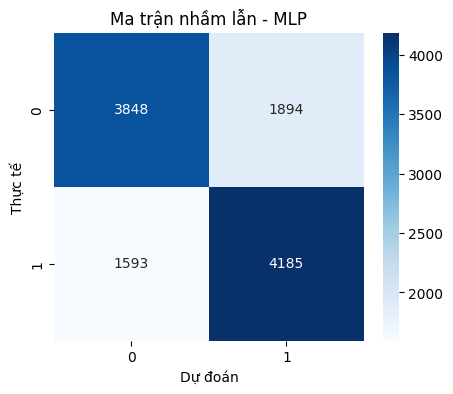

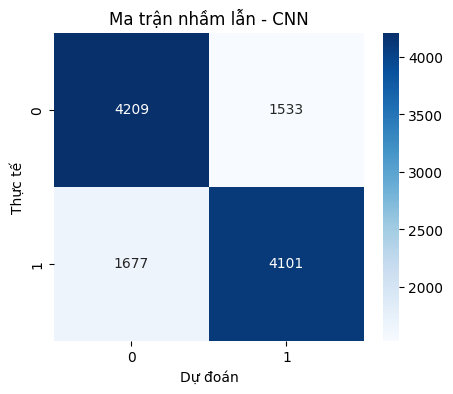

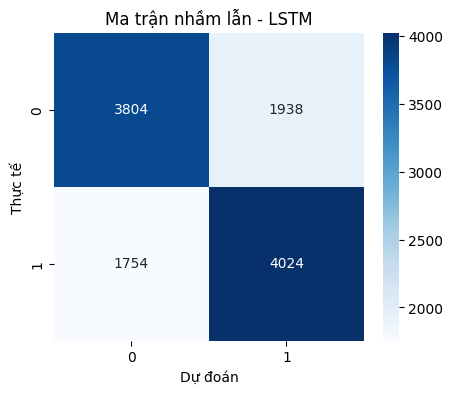

In [13]:
def ve_confusion(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Ma trận nhầm lẫn - {name}")
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.show()

ve_confusion(y_test, y_pred_mlp, "MLP")
ve_confusion(y_test, y_pred_cnn, "CNN")
ve_confusion(y_test, y_pred_lstm, "LSTM")

# 9. Biểu đồ training history

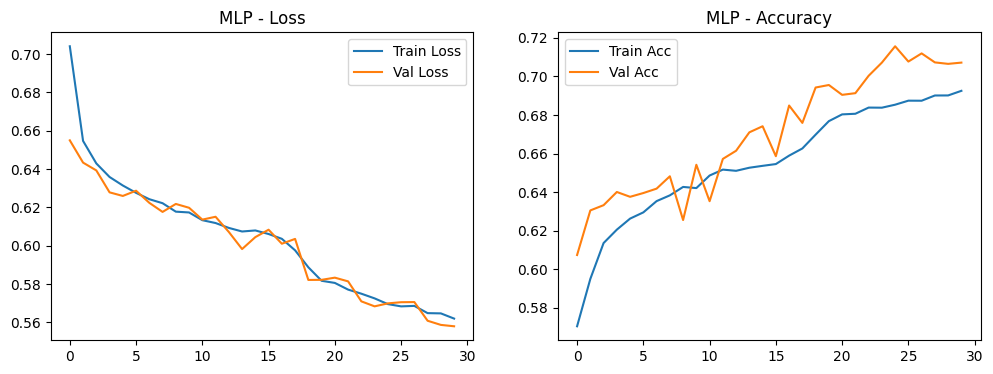

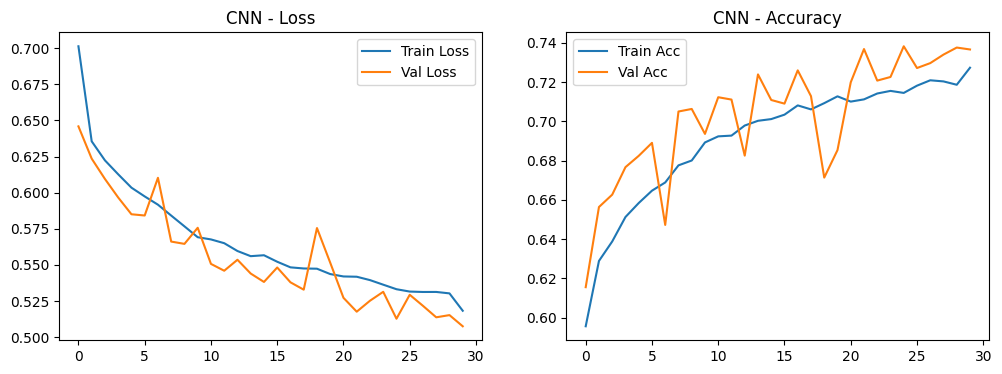

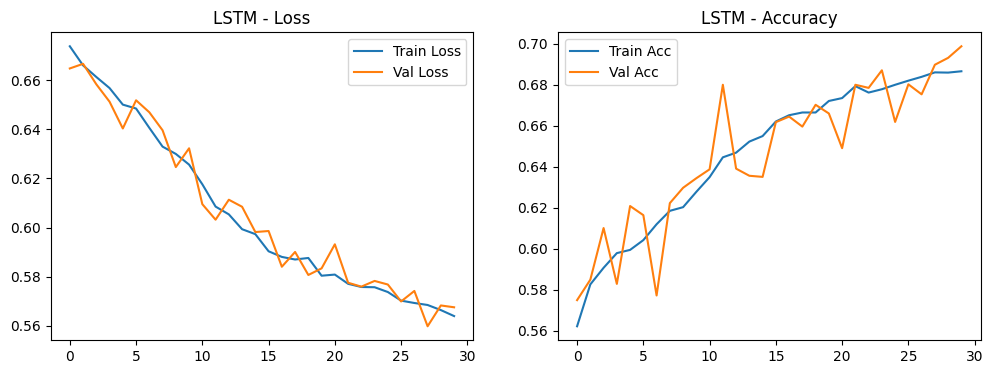

In [14]:
def ve_history(hist, name):
    plt.figure(figsize=(12,4))
    # loss
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f"{name} - Loss")
    plt.legend()

    # accuracy
    plt.subplot(1,2,2)
    if 'accuracy' in hist.history:
        plt.plot(hist.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in hist.history:
        plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f"{name} - Accuracy")
    plt.legend()

    plt.show()

ve_history(histories["MLP"], "MLP")
ve_history(histories["CNN"], "CNN")
ve_history(histories["LSTM"], "LSTM")

# 10. So sánh mô hình

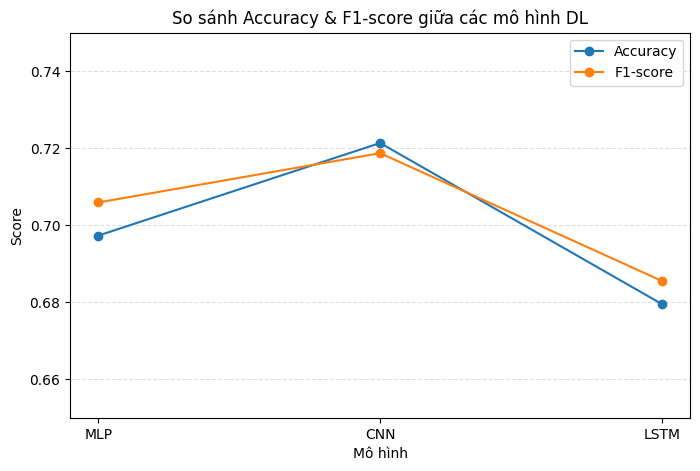

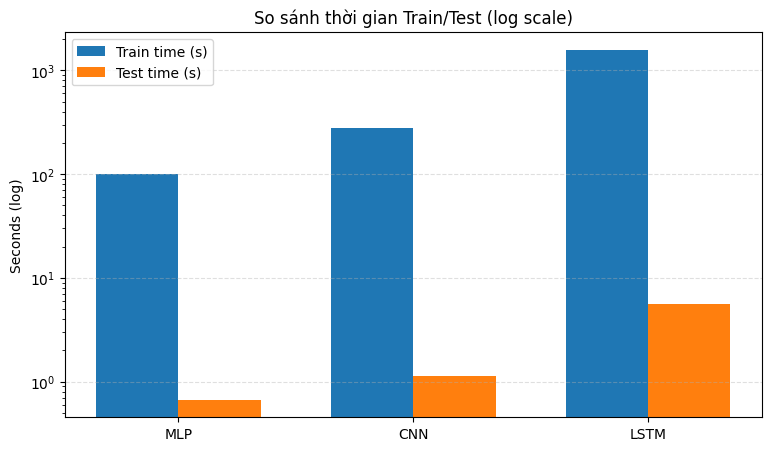

In [17]:
names = list(results.keys())
accs = [results[m]["acc"] for m in names]
f1s  = [results[m]["f1"] for m in names]

plt.figure(figsize=(8,5))
plt.plot(names, accs, marker='o', label="Accuracy")
plt.plot(names, f1s, marker='o', label="F1-score")
plt.ylim(0.65, 0.75)
plt.title("So sánh Accuracy & F1-score giữa các mô hình DL")
plt.xlabel("Mô hình")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


train_times = [results[m]["train_time"] for m in names]
test_times  = [results[m]["test_time"] for m in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, train_times, width, label="Train time (s)")
plt.bar(x + width/2, test_times, width, label="Test time (s)")
plt.xticks(x, names)
plt.yscale("log")
plt.title("So sánh thời gian Train/Test (log scale)")
plt.ylabel("Seconds (log)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# 11. Bảng tổng hợp

In [16]:
summary = pd.DataFrame(results).T
summary = summary[['acc','f1','train_time','test_time']]
summary = summary.rename(columns={
    'acc': 'Accuracy',
    'f1': 'F1',
    'train_time': 'Train_time_s',
    'test_time': 'Test_time_s'
})

print("\n=== BẢNG TỔNG HỢP KẾT QUẢ DEEP LEARNING (BINARY) ===")
print(summary)


=== BẢNG TỔNG HỢP KẾT QUẢ DEEP LEARNING (BINARY) ===
      Accuracy        F1  Train_time_s  Test_time_s
MLP   0.697309  0.705912     99.458557     0.670238
CNN   0.721354  0.718717    281.373249     1.123386
LSTM  0.679514  0.685520   1579.002508     5.580703
